# Introduction
The goal of the project is to use past movie ratings to predict how users will rate movies they haven't watched yet.

## Data
The data is a subset of the movie ratings data from [MovieLens](https://movielens.org). It includes:

* **users.csv**: Information about 2353 movie watchers. Each line has three fields: userID, age (see notes below), gender ("F" or "M")

* **movies.tsv**: Information about 1465 movies. Each line has six fields: movieID, name, year, genre1, genre2, genre3. If a movie has fewer than three genres the extra fields are blank.

* **ratings.csv**: 31,620 movie ratings. Each line has three fields: userID, movieID, rating. The userID and movieID correspond to those in the users.csv and movies.tsv files, respectively. Ratings are integers in the range 1 to 5 (from worst to best).

* **allData.tsv**: For those who prefer having everything in one place, this file contains the combined information from the previous three files. Each line has 10 fields: userID, age, gender, movieID, name, year, genre1, genre2, genre3, rating

* **predict.csv**: Ratings for you to predict. Each line has three fields: userID, movieID, rating, with all ratings set initially to 0. There are no ratings for these userID-movieID pairs in ratings.csv.

## Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load data

In [2]:
users = pd.read_csv('/content/drive/My Drive/Online Courses/CS102: Working with data/Project 2/Data/users.csv')
ratings = pd.read_csv('/content/drive/My Drive/Online Courses/CS102: Working with data/Project 2/Data/ratings.csv')
movies = pd.read_csv('/content/drive/My Drive/Online Courses/CS102: Working with data/Project 2/Data/movies.tsv', sep = '\t')

# Data Cleaning

## Users data

In [3]:
# Use the head() function to get a quick look at the data 
users.head()

,userID,age,gender
0,4,25,M
1,5,56,M
2,6,50,M
3,15,45,M
4,17,25,F


In [4]:
# Brief infomation about data
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2353 entries, 0 to 2352
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userID  2353 non-null   int64 
 1   age     2353 non-null   int64 
 2   gender  2353 non-null   object
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


**No missing values in users data**

## Movies data

In [5]:
# Use the head() function to get a quick look at the data 
movies.head()

,movieID,name,year,genre1,genre2,genre3
0,1,Toy Story,1995,Animation,Children's,Comedy
1,2,Jumanji,1995,Adventure,Children's,Fantasy
2,3,Grumpier Old Men,1995,Comedy,Romance,NaN
3,4,Waiting to Exhale,1995,Comedy,Drama,NaN
4,5,Father of the Bride Part II,1995,Comedy,NaN,NaN


In [6]:
# Brief infomation about data
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieID  1465 non-null   int64 
 1   name     1465 non-null   object
 2   year     1465 non-null   int64 
 3   genre1   1465 non-null   object
 4   genre2   871 non-null    object
 5   genre3   299 non-null    object
dtypes: int64(2), object(4)
memory usage: 68.8+ KB


**There are missing values in genre columns. However, these NaN values doesn't need to be deleted.**

## Ratings data

In [7]:
# Use the head() function to get a quick look at the data 
ratings.head()

,userID,movieID,rating
0,747,1193,5
1,747,661,3
2,747,2804,5
3,747,919,4
4,747,2791,4


In [8]:
# Brief infomation about data
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31620 entries, 0 to 31619
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   userID   31620 non-null  int64
 1   movieID  31620 non-null  int64
 2   rating   31620 non-null  int64
dtypes: int64(3)
memory usage: 741.2 KB


**No missing values in ratings data**

# Exploratory Data Analysis

## 1) How was the age distributed ?

Text(0.5, 0, 'Age')

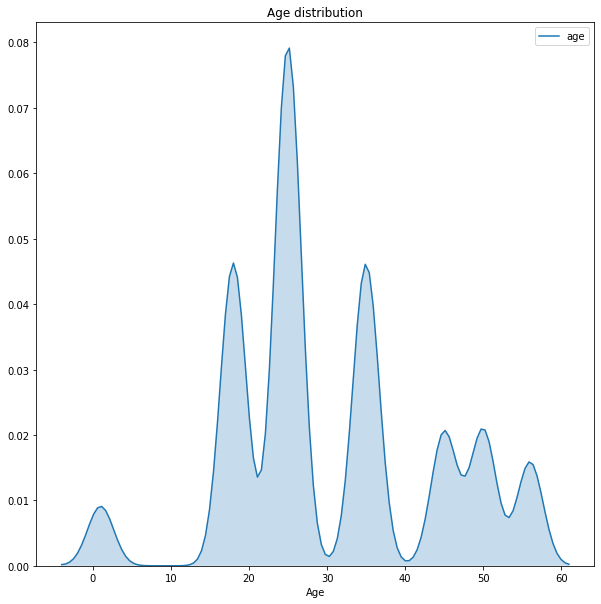

In [9]:
plt.figure(figsize = (10, 10))
sns.kdeplot(users['age'], shade = True)
plt.title('Age distribution')
plt.xlabel('Age')

## 2) What are the types of movie ?

In [10]:
movies['genre1'].unique()

array(['Animation', 'Adventure', 'Comedy', 'Action', 'Drama', 'Romance',
       "Children's", 'Crime', 'Documentary', 'Thriller', 'Horror',
       'Western', 'Mystery', 'Film-Noir', 'Sci-Fi', 'Musical', 'War'],
      dtype=object)

## 3) What is the percentage of each movie type in movies data ?

In [11]:
movie_percent = movies[['movieID', 'genre1']].groupby(['genre1']).count().apply(lambda x: x/x.sum()).rename(columns={'movieID': 'Percentage'})
movie_percent

,Percentage
genre1,
Action,0.157679
Adventure,0.052560
Animation,0.035495
Children's,0.028669
Comedy,0.301706
Crime,0.034812
Documentary,0.015700
Drama,0.245051
Film-Noir,0.008874


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


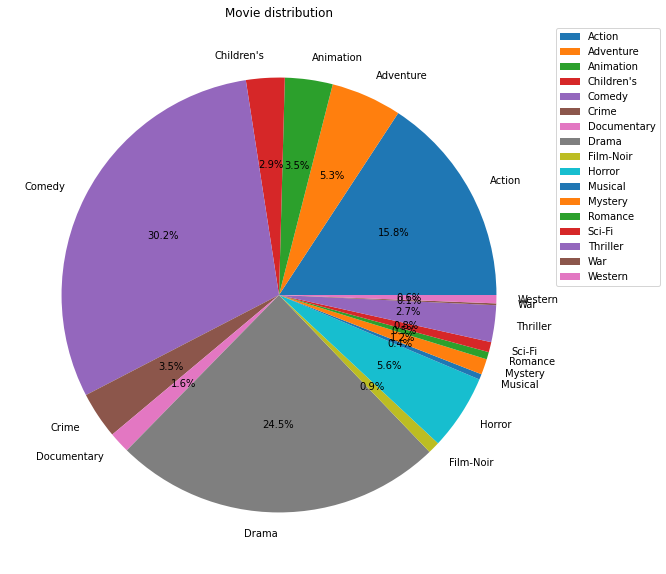

In [12]:
plt.figure(figsize = (10, 10))
plt.pie(x = movie_percent, autopct='%1.1f%%', labels = movie_percent.index)
plt.title('Movie distribution')
plt.legend(labels = movie_percent.index,  bbox_to_anchor=(1, 1))

## 4) Which was the best Action movie (based on average ratings)?

In [13]:
pd.merge(movies, ratings, how='inner', on = 'movieID').head()

,movieID,name,year,genre1,genre2,genre3,userID,rating
0,1,Toy Story,1995,Animation,Children's,Comedy,3073,5
1,1,Toy Story,1995,Animation,Children's,Comedy,4890,2
2,1,Toy Story,1995,Animation,Children's,Comedy,5125,4
3,1,Toy Story,1995,Animation,Children's,Comedy,70,5
4,1,Toy Story,1995,Animation,Children's,Comedy,2948,4


In [14]:
movie_ratings = pd.merge(movies, ratings, how='inner', on = 'movieID')
movie_ratings.head()

,movieID,name,year,genre1,genre2,genre3,userID,rating
0,1,Toy Story,1995,Animation,Children's,Comedy,3073,5
1,1,Toy Story,1995,Animation,Children's,Comedy,4890,2
2,1,Toy Story,1995,Animation,Children's,Comedy,5125,4
3,1,Toy Story,1995,Animation,Children's,Comedy,70,5
4,1,Toy Story,1995,Animation,Children's,Comedy,2948,4


In [15]:
action_ratings = movie_ratings[movie_ratings['genre1'] == 'Action'][['movieID', 'rating']].groupby(['movieID']).mean().sort_values(by = 'rating', ascending = False)
action_ratings

,rating
movieID,
1387,5.0
2393,5.0
1233,5.0
1552,5.0
3267,5.0
...,...
2529,1.0
836,1.0
2275,1.0


In [16]:
movies.set_index(keys = 'movieID').loc[action_ratings.index]

,name,year,genre1,genre2,genre3
movieID,,,,,
1387,Jaws,1975,Action,Horror,NaN
2393,Star Trek: Insurrection,1998,Action,Sci-Fi,NaN
1233,"Boat, The (Das Boot)",1981,Action,Drama,War
1552,Con Air,1997,Action,Adventure,Thriller
3267,"Mariachi, El",1992,Action,Thriller,NaN
...,...,...,...,...,...
2529,Planet of the Apes,1968,Action,Sci-Fi,NaN
836,Chain Reaction,1996,Action,Adventure,Thriller
2275,Six-String Samurai,1998,Action,Adventure,Sci-Fi


# Feature Engineering

In [17]:
# First of all, all three data must combine into one
all = pd.merge(users, movie_ratings, on = 'userID')
all

,userID,age,gender,movieID,name,year,genre1,genre2,genre3,rating
0,4,25,M,86,White Squall,1996,Adventure,Drama,NaN,3
1,4,25,M,145,Bad Boys,1995,Action,NaN,NaN,4
2,4,25,M,376,"River Wild, The",1994,Action,Thriller,NaN,3
3,4,25,M,485,Last Action Hero,1993,Action,Comedy,NaN,2
4,4,25,M,1727,"Horse Whisperer, The",1998,Drama,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...
31615,6030,25,M,3793,X-Men,2000,Action,Sci-Fi,NaN,4
31616,6030,25,M,3948,Meet the Parents,2000,Comedy,NaN,NaN,4
31617,6030,25,M,3949,Requiem for a Dream,2000,Drama,NaN,NaN,4
31618,6038,50,M,2329,American History X,1998,Drama,NaN,NaN,4


In [18]:
# First of all, all three data must combine into one
all['genres'] = all['genre1'].apply(lambda x: '' if pd.isnull(x) else x) + all['genre2'].apply(lambda x: '' if pd.isnull(x) else '|' + x) + all['genre3'].apply(lambda x: '' if pd.isnull(x) else '|' + x)

In [19]:
# use unique() to show all unique values in 'genres'
all['genres'].unique()

array(['Adventure|Drama', 'Action', 'Action|Thriller', 'Action|Comedy',
       'Drama', 'Action|Drama|Thriller', 'Comedy|Drama',
       'Action|Comedy|Fantasy', 'Action|Adventure|Drama',
       'Comedy|Drama|Sci-Fi', 'Action|Crime|Thriller', 'Comedy|Musical',
       'Comedy|Drama|Romance', 'Comedy|Musical|Romance',
       'Musical|Romance', 'Drama|Mystery', 'Action|Adventure|Thriller',
       'Comedy|Crime', 'Comedy|War', "Children's|Comedy|Romance",
       'Film-Noir|Thriller', 'Comedy', 'Crime|Thriller', 'Drama|Thriller',
       'Action|Adventure|Sci-Fi', 'Animation', 'Action|Adventure|Romance',
       'Drama|War', 'Horror|Thriller', 'Comedy|Sci-Fi', 'Drama|Romance',
       'Crime|Mystery|Thriller', "Animation|Children's|Musical",
       'Crime|Drama', 'Action|Adventure|Horror', 'Horror|Sci-Fi',
       'Action|Sci-Fi|Thriller', 'Comedy|Fantasy', 'Thriller',
       'Comedy|Romance', 'Adventure|Drama|Thriller', 'Action|Sci-Fi',
       'Action|Horror|Sci-Fi', "Children's|Sci-Fi", 'Horro

In [20]:
# Drop 3 columns genre1, genre2, genre3
all.drop(labels = ['genre1', 'genre2', 'genre3'], axis = 1, inplace = True)
all.head()

,userID,age,gender,movieID,name,year,rating,genres
0,4,25,M,86,White Squall,1996,3,Adventure|Drama
1,4,25,M,145,Bad Boys,1995,4,Action
2,4,25,M,376,"River Wild, The",1994,3,Action|Thriller
3,4,25,M,485,Last Action Hero,1993,2,Action|Comedy
4,4,25,M,1727,"Horse Whisperer, The",1998,3,Drama


In [21]:
# Selected 'age', 'gender', 'genres' and 'rating' as features to build model.
selected_data = all[[
    'age',
    'gender',
    'genres',
    'rating'
]]
selected_data.head()

,age,gender,genres,rating
0,25,M,Adventure|Drama,3
1,25,M,Action,4
2,25,M,Action|Thriller,3
3,25,M,Action|Comedy,2
4,25,M,Drama,3


In [22]:
# As genres column contains category values, get_dummies() function must be used to perform one-hot encoding
genres = selected_data['genres']
genres = genres.str.get_dummies().add_prefix('genres_')
selected_data = pd.concat([selected_data.drop(['genres'], axis = 1), genres], axis = 1)

selected_data.head()

,age,gender,rating,genres_Action,genres_Adventure,genres_Animation,genres_Children's,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Fantasy,genres_Film-Noir,genres_Horror,genres_Musical,genres_Mystery,genres_Romance,genres_Sci-Fi,genres_Thriller,genres_War,genres_Western
0,25,M,3,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,25,M,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,25,M,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,25,M,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,25,M,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [23]:
# Gender feature aslo a category variable, so It need to be perfomed one-hot encoding as well
selected_data = pd.get_dummies(selected_data, columns = ['gender'])
selected_data.head()

,age,rating,genres_Action,genres_Adventure,genres_Animation,genres_Children's,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Fantasy,genres_Film-Noir,genres_Horror,genres_Musical,genres_Mystery,genres_Romance,genres_Sci-Fi,genres_Thriller,genres_War,genres_Western,gender_F,gender_M
0,25,3,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,25,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,25,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,25,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,25,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [24]:
# all columns in selected_data
selected_data.columns

Index(['age', 'rating', 'genres_Action', 'genres_Adventure',
       'genres_Animation', 'genres_Children's', 'genres_Comedy',
       'genres_Crime', 'genres_Documentary', 'genres_Drama', 'genres_Fantasy',
       'genres_Film-Noir', 'genres_Horror', 'genres_Musical', 'genres_Mystery',
       'genres_Romance', 'genres_Sci-Fi', 'genres_Thriller', 'genres_War',
       'genres_Western', 'gender_F', 'gender_M'],
      dtype='object')

In [25]:
# Check types in selected_data
selected_data.dtypes

age                   int64
rating                int64
genres_Action         int64
genres_Adventure      int64
genres_Animation      int64
genres_Children's     int64
genres_Comedy         int64
genres_Crime          int64
genres_Documentary    int64
genres_Drama          int64
genres_Fantasy        int64
genres_Film-Noir      int64
genres_Horror         int64
genres_Musical        int64
genres_Mystery        int64
genres_Romance        int64
genres_Sci-Fi         int64
genres_Thriller       int64
genres_War            int64
genres_Western        int64
gender_F              uint8
gender_M              uint8
dtype: object

**This code below is to check correlation between variables and then drop any high correlated variable.**

In [26]:
corr_matrix = selected_data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.2
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]
# Drop features

if 'gender_M' in to_drop:
    to_drop.remove('gender_M')

if 'gender_F' in to_drop:
    to_drop.remove('gender_F')

new_selected_data = selected_data.drop(selected_data[to_drop], axis=1)

new_selected_data.head()

,age,rating,genres_Action,genres_Adventure,genres_Animation,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Fantasy,genres_Film-Noir,genres_Horror,genres_Musical,genres_Mystery,genres_Romance,genres_Sci-Fi,genres_Thriller,genres_War,genres_Western,gender_F,gender_M
0,25,3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,25,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,25,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,25,2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,25,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


# Data Modeling

In [27]:
# Drop rating feature and make it an output
X = new_selected_data.drop(['rating'], axis = 1)
Y = new_selected_data['rating']

# Split train and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .2)

# Use XGBoost regressor as a model
model = XGBRegressor(max_depth = 10, n_estimators=500)
model.fit(X_train, y_train)

# Predict and assign it into y_pred
y_pred = model.predict(X_test)
y_pred

[16:56:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([3.6467578, 3.3426242, 3.6591835, ..., 3.437536 , 3.8267193,
       3.829964 ], dtype=float32)

# Evaluation

In [28]:
# MAE
print(
    'Mean Abs Error  MAE: ',
    metrics.mean_absolute_error(y_test, y_pred)
)

# MSE
print(
    'Mean Sq Error  MSE: ',
    metrics.mean_squared_error(y_test, y_pred)
)

# RMSE
print(
    'Root Mean Sq Error RMSE:',
    np.sqrt(metrics.mean_squared_error(y_test, y_pred))
)

# R2
print(
    'r2 value: ',
    metrics.r2_score(y_test, y_pred)
)

Mean Abs Error  MAE:  0.8859578493574916
Mean Sq Error  MSE:  1.2017878127236712
Root Mean Sq Error RMSE: 1.0962608324316212
r2 value:  0.03471114087763272


In [29]:
# prediction dataframe
prediction_df = pd.DataFrame({'Test': y_test, 'Prediction': y_pred})
prediction_df.head()

,Test,Prediction
8547,5,3.646758
4564,4,3.342624
24140,2,3.659184
23392,4,3.604869
28468,4,3.227617
